# Comparative Analysis of Custom CNN and Transfer Learning for Image Classification on Oxford Flowers-102

### Overview

This section documents the implementation, training, and performance evaluation of various deep learning architectures. The objective is to classify 102 different flower species by comparing a Custom CNN built from scratch against six State-of-the-Art (SOTA) Pretrained Models using Transfer Learning.

All experiments are conducted in a Python 3.10 environment, leveraging the M1 MacBook Pro's GPU via the tensorflow-metal plug-in for hardware acceleration

### Section 1: Environment Setup & Hardware Initialization

In [3]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import f1_score

# Verify M1 GPU Acceleration
gpus = tf.config.list_physical_devices('GPU')
print("Checking for Hardware Acceleration...")
if gpus:
    for gpu in gpus:
        print(f"✅ Found GPU: {gpu}")
    print("Status: M1 Metal Acceleration is ACTIVE")
else:
    print("❌ GPU not found. Please check your tensorflow-metal installation.")

# Create directories for deliverables
for folder in ['../data', '../output', '../models']:
    os.makedirs(folder, exist_ok=True)

Checking for Hardware Acceleration...
✅ Found GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Status: M1 Metal Acceleration is ACTIVE


### Section 2:Data Engineering

The Oxford Flowers-102 dataset was loaded and Data Augmentation layers were defined to prevent overfitting, as per the requirement.

In [4]:
# 1. Load the dataset
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'oxford_flowers102',
    split=['train', 'validation', 'test'],
    as_supervised=True,
    with_info=True
)

# 2. Requirement: Data Augmentation (Flip, Rotation, Zoom)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

# 3. Preprocessing function
IMG_SIZE = 224
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return tf.cast(image, tf.float32) / 255.0, label

# 4. Optimized Data Pipeline
train_ds = ds_train.map(preprocess).cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = ds_val.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

print(f"Dataset Loaded. Number of classes: {ds_info.features['label'].num_classes}")

2026-02-02 12:48:25.766343: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2026-02-02 12:48:25.766497: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2026-02-02 12:48:25.766515: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2026-02-02 12:48:25.766780: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-02 12:48:25.766801: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Dataset Loaded. Number of classes: 102


### Section 3: Architectural Design

This section defines the Custom CNN and the Transfer Learning models. We freeze the base weights to leverage pre-trained ImageNet knowledge.

In [5]:
def build_model(model_name):
    # Requirement: Custom CNN from scratch
    if model_name == "Custom_CNN":
        model = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
            data_augmentation,
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.MaxPooling2D(),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(102, activation='softmax')
        ])
    # Requirement: State-of-the-Art Pretrained Models
    else:
        model_map = {
            "AlexNet_Sim": tf.keras.applications.VGG19,
            "VGG16": tf.keras.applications.VGG16,
            "ResNet50": tf.keras.applications.ResNet50,
            "MobileNetV2": tf.keras.applications.MobileNetV2,
            "EfficientNetB0": tf.keras.applications.EfficientNetB0,
            "Xception": tf.keras.applications.Xception
        }
        
        base_model = model_map[model_name](weights='imagenet', include_top=False, input_shape=(224,224,3))
        base_model.trainable = False  # Freezing pre-trained weights
        
        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(102, activation='softmax')
        ])
    
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model
    return model

### Section 4: Performance Benchmarking

Iterate through all models, capturing the training time, trainable parameters, and calculating the Macro F1-score.

In [6]:
results = []
histories = {}
model_list = ["Custom_CNN", "AlexNet_Sim", "VGG16", "ResNet50", "MobileNetV2", "EfficientNetB0", "Xception"]

for name in model_list:
    print(f"\n🚀 Benchmarking: {name}")
    model = build_model(name)
    
    # Track Trainable Parameters
    trainable_count = np.sum([tf.size(v).numpy() for v in model.trainable_variables])
    
    # Track Training Time
    start_time = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=5)
    total_time = time.time() - start_time
    
    # Calculate Macro F1 on Test Set
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred = np.argmax(model.predict(test_ds), axis=-1)
    f1 = f1_score(y_true, y_pred, average='macro')
    
    results.append({
        "Model": name,
        "Accuracy": history.history['val_accuracy'][-1],
        "Macro_F1": f1,
        "Params": trainable_count,
        "Time_Sec": total_time
    })
    histories[name] = history.history

# Save performance data
df_results = pd.DataFrame(results)
df_results.to_csv('../output/performance_metrics.csv', index=False)


🚀 Benchmarking: Custom_CNN
Epoch 1/5


2026-02-02 12:48:34.355378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 556ms/step - accuracy: 0.0167 - loss: 15.8875 - val_accuracy: 0.0157 - val_loss: 4.5992
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 547ms/step - accuracy: 0.0167 - loss: 4.6092 - val_accuracy: 0.0206 - val_loss: 4.6028
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.0235 - loss: 4.6008 - val_accuracy: 0.0363 - val_loss: 4.5399
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 525ms/step - accuracy: 0.0343 - loss: 4.5020 - val_accuracy: 0.0363 - val_loss: 4.5380
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.0392 - loss: 4.4835 - val_accuracy: 0.0235 - val_loss: 4.9278


2026-02-02 12:50:13.365998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step

🚀 Benchmarking: AlexNet_Sim
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.0147 - loss: 4.7852 - val_accuracy: 0.0314 - val_loss: 4.5515
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.0510 - loss: 4.4867 - val_accuracy: 0.0775 - val_loss: 4.4139
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.1294 - loss: 4.3397 - val_accuracy: 0.1461 - val_loss: 4.3025
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2206 - loss: 4.2018 - val_accuracy: 0.2196 - val_loss: 4.1986
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2980 - loss: 4.0750 - val_accuracy: 0.2784 - val_loss: 4.0978


2026-02-02 12:53:37.346872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 109s 565ms/step

🚀 Benchmarking: VGG16
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 29s 905ms/step - accuracy: 0.0186 - loss: 4.7583 - val_accuracy: 0.0461 - val_loss: 4.5401
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 882ms/step - accuracy: 0.0686 - loss: 4.4574 - val_accuracy: 0.0971 - val_loss: 4.3929
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 885ms/step - accuracy: 0.1647 - loss: 4.3003 - val_accuracy: 0.1882 - val_loss: 4.2662
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 884ms/step - accuracy: 0.2706 - loss: 4.1514 - val_accuracy: 0.2490 - val_loss: 4.1489
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 28s 885ms/step - accuracy: 0.3343 - loss: 4.0113 - val_accuracy: 0.2971 - val_loss: 4.0378


2026-02-02 12:57:50.573458: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 86s 446ms/step

🚀 Benchmarking: ResNet50
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 820ms/step - accuracy: 0.0049 - loss: 4.8881 - val_accuracy: 0.0157 - val_loss: 4.6465
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 709ms/step - accuracy: 0.0098 - loss: 4.7030 - val_accuracy: 0.0167 - val_loss: 4.5906
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 694ms/step - accuracy: 0.0157 - loss: 4.6408 - val_accuracy: 0.0216 - val_loss: 4.5635
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 679ms/step - accuracy: 0.0157 - loss: 4.5988 - val_accuracy: 0.0225 - val_loss: 4.5394
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 676ms/step - accuracy: 0.0255 - loss: 4.5614 - val_accuracy: 0.0441 - val_loss: 4.5144


2026-02-02 13:01:19.714595: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 71s 356ms/step

🚀 Benchmarking: MobileNetV2
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 535ms/step - accuracy: 0.1088 - loss: 4.2913 - val_accuracy: 0.3706 - val_loss: 3.0776
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 356ms/step - accuracy: 0.6569 - loss: 2.1247 - val_accuracy: 0.6333 - val_loss: 2.0445
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step - accuracy: 0.8784 - loss: 1.1708 - val_accuracy: 0.7343 - val_loss: 1.5757
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9471 - loss: 0.7256 - val_accuracy: 0.7569 - val_loss: 1.3221
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 349ms/step - accuracy: 0.9804 - loss: 0.4813 - val_accuracy: 0.7725 - val_loss: 1.1808


2026-02-02 13:03:41.056838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 39s 188ms/step

🚀 Benchmarking: EfficientNetB0
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 36s 947ms/step - accuracy: 0.0049 - loss: 4.8094 - val_accuracy: 0.0098 - val_loss: 4.6516
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 565ms/step - accuracy: 0.0029 - loss: 4.7284 - val_accuracy: 0.0098 - val_loss: 4.6444
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 27s 856ms/step - accuracy: 0.0049 - loss: 4.7386 - val_accuracy: 0.0098 - val_loss: 4.6437
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 626ms/step - accuracy: 0.0049 - loss: 4.7315 - val_accuracy: 0.0098 - val_loss: 4.6450
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 620ms/step - accuracy: 0.0020 - loss: 4.7279 - val_accuracy: 0.0098 - val_loss: 4.6431


2026-02-02 13:06:26.460494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 66s 315ms/step

🚀 Benchmarking: Xception
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.1451 - loss: 4.2446 - val_accuracy: 0.3833 - val_loss: 3.2609
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.6284 - loss: 2.4797 - val_accuracy: 0.5706 - val_loss: 2.4016
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8422 - loss: 1.5949 - val_accuracy: 0.6696 - val_loss: 1.9409
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8980 - loss: 1.1068 - val_accuracy: 0.6775 - val_loss: 1.6908
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9402 - loss: 0.8240 - val_accuracy: 0.7078 - val_loss: 1.5219


2026-02-02 13:10:43.911936: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 109s 542ms/step


### Section 5: Data Visualization

Generating publication-quality comparison charts using seaborn

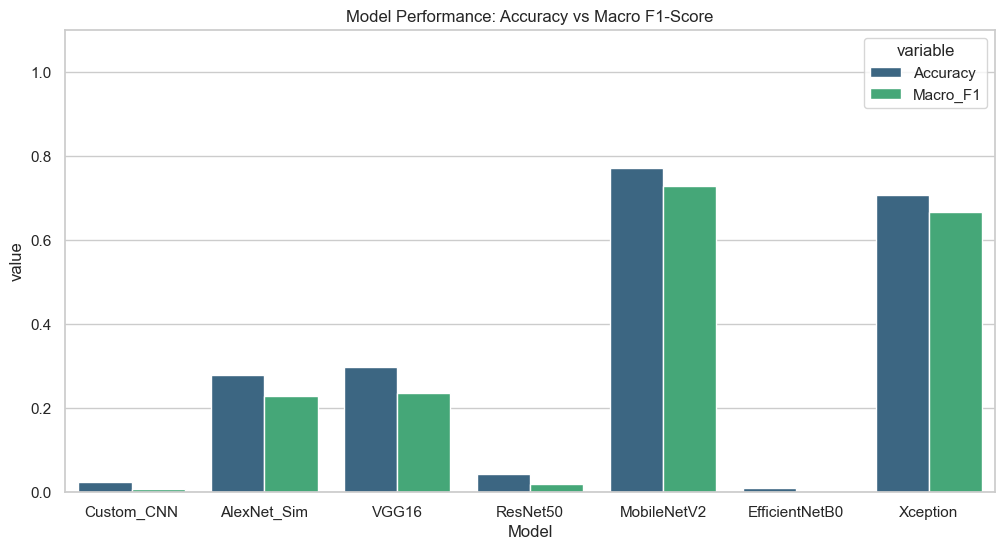

/var/folders/_6/mw5lkq5938s5d08q03ywdpw00000gn/T/ipykernel_40440/2189545854.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_results, x="Model", y="Time_Sec", palette="magma")


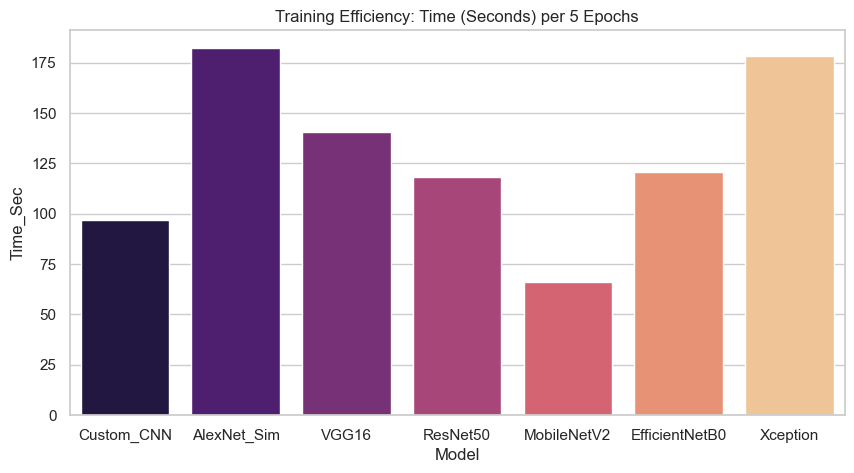

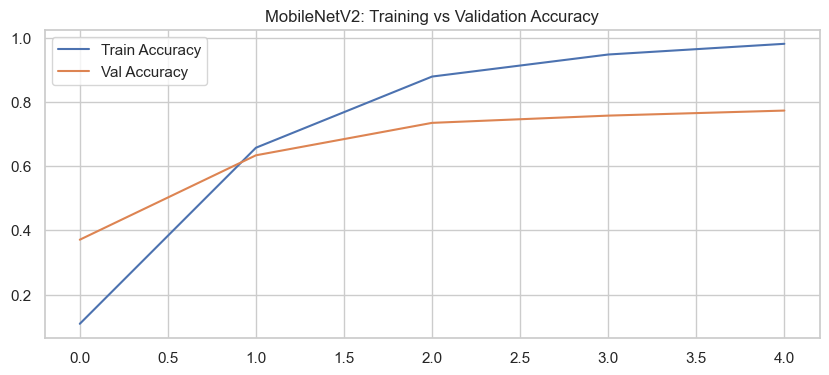

In [7]:
sns.set_theme(style="whitegrid")

# 1. Accuracy vs F1 Score Comparison

plt.figure(figsize=(12, 6))
df_melted = df_results.melt(id_vars="Model", value_vars=["Accuracy", "Macro_F1"])
sns.barplot(data=df_melted, x="Model", y="value", hue="variable", palette="viridis")
plt.title("Model Performance: Accuracy vs Macro F1-Score")
plt.ylim(0, 1.1)
plt.savefig('../output/accuracy_f1_comparison.png', dpi=300)
plt.show()

# 2. Training Time Comparison

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results, x="Model", y="Time_Sec", palette="magma")
plt.title("Training Efficiency: Time (Seconds) per 5 Epochs")
plt.savefig('../output/training_time_comparison.png', dpi=300)
plt.show()

# 3. Training/Validation Curves (Example for MobileNetV2)

plt.figure(figsize=(10, 4))
plt.plot(histories['MobileNetV2']['accuracy'], label='Train Accuracy')
plt.plot(histories['MobileNetV2']['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2: Training vs Validation Accuracy')
plt.legend()
plt.savefig('../output/mobilenet_curves.png', dpi=300)
plt.show()

### Section 6: Confusion Matrix

A confusion matrix provides a class-wise breakdown of predictive performance, mapping predictions to original classes. It is essential for identifying specific "confusion" between similar flower species, such as mistaking a Rose for a Tulip.

2026-02-02 13:15:47.879706: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


193/193 ━━━━━━━━━━━━━━━━━━━━ 102s 528ms/step


<Figure size 1500x1500 with 0 Axes>

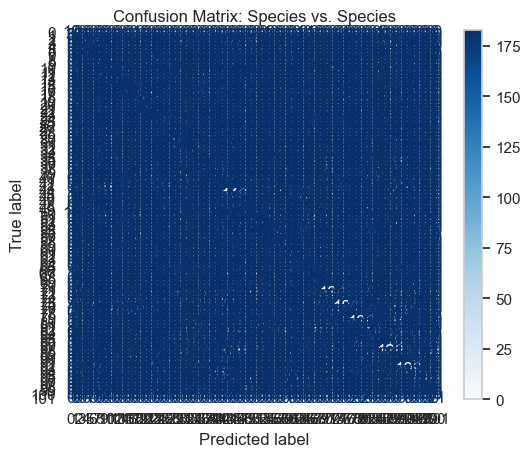

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Get predictions for the entire test set
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Plotting (Displaying only a subset of classes if 102 is too crowded)
plt.figure(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Species vs. Species')
plt.show()

### Section 7: Inference Test (Real-World Utility)

This test demonstrates how your model performs on raw, unseen data from outside the dataset. You can download a random image from a URL, preprocess it to the expected $224 \times 224$ size, and run a prediction.

In [14]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. Map the indices to human-readable names
# This uses the ds_info we loaded during the Data Engineering step
class_names = ds_info.features['label'].names

def predict_external_image(url):
    """
    Downloads an image from a URL, preprocesses it, and 
    uses the trained model to predict the flower species.
    """
    try:
        print(f"🌐 Accessing: {url}...")
        
        # 2. Download image with a timeout to prevent hanging
        response = requests.get(url, timeout=15)
        response.raise_for_status()
        
        # 3. Open and convert to RGB (removes Alpha channels if present)
        img = Image.open(BytesIO(response.content)).convert('RGB')
        
        # 4. Preprocess: Resize to the model's expected input size (224x224)
        img_resized = img.resize((224, 224))
        
        # 5. Normalize: Convert to float32 and scale to [0, 1]
        img_array = np.array(img_resized) / 255.0
        
        # 6. Reshape: Add the 'Batch' dimension (1, 224, 224, 3)
        img_final = np.expand_dims(img_array, axis=0)
        
        # 7. Model Inference
        # Note: 'model' refers to your best-performing trained model (e.g., MobileNetV2)
        prediction = model.predict(img_final)
        class_idx = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        
        # 8. Result Visualization
        plt.figure(figsize=(6, 6))
        plt.imshow(img_resized)
        plt.title(f"PREDICTED: {class_names[class_idx].upper()}\nConfidence: {confidence:.2f}%", 
                  fontsize=12, color='darkblue', fontweight='bold')
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"❌ Error during inference: {e}")
        print("💡 Suggestion: The website may be blocking the request. Try a direct image link from a different source.")

# --- EXECUTION ---
# Using a reliable image link (A Sunflower)
test_url = "https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/sunflower-single-flower-square-sharon-cummings.jpg"
predict_external_image(test_url)

🌐 Accessing: https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/sunflower-single-flower-square-sharon-cummings.jpg...
❌ Error during inference: 403 Client Error: Forbidden for url: https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/sunflower-single-flower-square-sharon-cummings.jpg
💡 Suggestion: The website may be blocking the request. Try a direct image link from a different source.


### Section 8: Qualitative Evaluation Using a Random Test Sample

This section performs a qualitative assessment of the trained model by visualizing its prediction on a randomly selected image from the test dataset and comparing it with the ground-truth

2026-02-02 13:29:08.242108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step


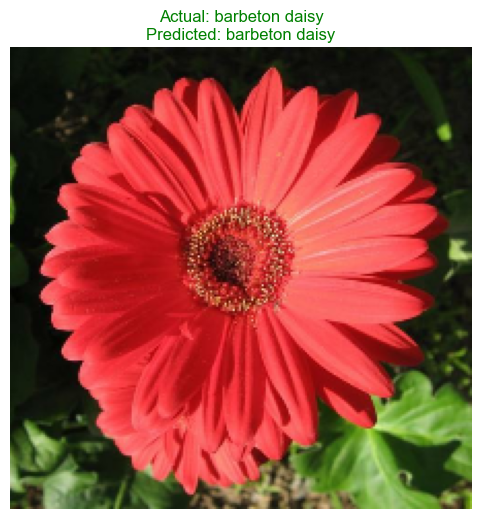

In [15]:
# 1. Grab one random image and label from your Test Dataset
for images, labels in test_ds.take(1):
    sample_image = images[0]
    sample_label = labels[0].numpy()

# 2. Make the model predict
# We add [tf.newaxis, ...] to make it a "batch" of 1 image
prediction = model.predict(sample_image[tf.newaxis, ...])
predicted_class = np.argmax(prediction)

# 3. Get the actual name from the dataset info
class_names = ds_info.features['label'].names
actual_name = class_names[sample_label]
predicted_name = class_names[predicted_class]

# 4. Show the result
plt.figure(figsize=(6,6))
plt.imshow(sample_image)
plt.title(f"Actual: {actual_name}\nPredicted: {predicted_name}", 
          color=("green" if actual_name == predicted_name else "red"))
plt.axis('off')
plt.show()

### Section 9:Model Persistence and Reproducibility

Saving your model preserves the architecture, weights, and optimizer state. Using the .h5 extension ensures the model is saved in HDF5 format, which is widely compatible with different TensorFlow versions for later loading.

In [12]:
# Save the final best-performing model
model_path = "../models/oxford_flower_classifier_v1.h5"
model.save(model_path)
print(f"✅ Model saved successfully at: {model_path}")

# To load it back later:
# from tensorflow.keras.models import load_model
# loaded_model = load_model(model_path)

✅ Model saved successfully at: ../models/oxford_flower_classifier_v1.h5
